---
title: sonar
---

## Implémentation de classifieurs binaires 

### Imports

In [1]:
from joblib import parallel_backend
parallel_backend("loky", n_jobs=-1)

In [2]:
import sys
sys.path.append("./../src/")

from get_dataset import dataset_loaders
dataset = list(dataset_loaders.keys())[6]
dataset

'bankmarketing'

In [3]:
# Parameters
dataset = "sonar"


In [4]:
from get_dataset import load_dataset

X, y = load_dataset(dataset)

### Data presentation

**{eval}`dataset`\** dataset contains `n` = {eval}`X.shape[0]` samples and `p` = {eval}`X.shape[1]` features.

The target variable is binary and {eval}`y.mean() * 100:.2f`% of the samples are positive.

In [5]:
from sklearn.model_selection import train_test_split

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

from sklearn.preprocessing import StandardScaler

# Normalize data using only the training set
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

#### Prepare model results storage

In [6]:
MODELS = dict()

def store_results(name, grid):
    MODELS[name] = {
        "best_params": grid.best_params_,
        "X_test": X_test,
        "y_true": y_test,
        "y_pred": grid.predict(X_test),
        "y_proba": grid.predict_proba(X_test)
    }
     
    pass

In [7]:
from sklearn.model_selection import GridSearchCV
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingRandomSearchCV

def get_grid(model, params):
    # grid = GridSearchCV(model, params, n_jobs=-1, cv=5)
    grid = HalvingRandomSearchCV(model, params, n_jobs=-1, cv=5, verbose=1, scoring="accuracy", refit=True)
    return grid

### Entraînement des classifieurs

#### Classifieurs non paramétriques

##### K-Nearest Neighbors

In [8]:
from sklearn.neighbors import KNeighborsClassifier

model = KNeighborsClassifier(weights='uniform', algorithm='auto')

param_grid = {
    'n_neighbors': [3, 5, 7, 9],
}

grid_search = get_grid(model, param_grid)

grid_search.fit(X_train, y_train)
store_results('KNN', grid_search)

n_iterations: 2
n_required_iterations: 2
n_possible_iterations: 2
min_resources_: 20
max_resources_: 145
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 4
n_resources: 20
Fitting 5 folds for each of 4 candidates, totalling 20 fits


/Users/mathisderenne/Documents/02 - Scolaire/M1 MIASHS/02 - Guillaume Mezler/Projet/.venv/lib/python3.12/site-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 4 is smaller than n_iter=7. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


----------
iter: 1
n_candidates: 2
n_resources: 60
Fitting 5 folds for each of 2 candidates, totalling 10 fits


##### Distance-Weighted KNN

In [9]:
model = KNeighborsClassifier(weights='distance', algorithm='auto')

param_grid = {
    'n_neighbors': [3, 5, 7, 9],
}

grid_search = get_grid(model, param_grid)

grid_search.fit(X_train, y_train)
store_results('KNN Distance Weighted', grid_search)

n_iterations: 2
n_required_iterations: 2
n_possible_iterations: 2
min_resources_: 20
max_resources_: 145
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 4
n_resources: 20
Fitting 5 folds for each of 4 candidates, totalling 20 fits
----------
iter: 1
n_candidates: 2
n_resources: 60
Fitting 5 folds for each of 2 candidates, totalling 10 fits


/Users/mathisderenne/Documents/02 - Scolaire/M1 MIASHS/02 - Guillaume Mezler/Projet/.venv/lib/python3.12/site-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 4 is smaller than n_iter=7. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


##### Condensed Nearest Neighbor

In [10]:
from imblearn.under_sampling import CondensedNearestNeighbour
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils import check_X_y
from sklearn.utils.validation import validate_data

# Wrap CondensedNearestNeighbour into an sklearn compatible transformer for use in pipelines
class CondensedNearestNeighbourTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, sampling_strategy = "auto", random_state = 42, n_neighbors = None, n_seeds_S = 1):
        self.sampling_strategy = sampling_strategy
        self.random_state = random_state
        self.n_neighbors = n_neighbors
        self.n_seeds_S = n_seeds_S

    def fit(self, X, y=None):
        # validate_data(X, y, accept_sparse=True, reset=True)
        self.n_features_in_ = X.shape[1]
        
        return self

    def transform(self, X, y=None):
        # check_X_y(X, y)

        if y is None:
            return X
        else:    
          return CondensedNearestNeighbour(
            sampling_strategy = self.sampling_strategy,
            random_state = self.random_state,
            n_neighbors = self.n_neighbors,
            n_seeds_S = self.n_seeds_S
          ).fit_resample(X, y)

from sklearn.utils.estimator_checks import check_estimator
# check_estimator(CondensedNearestNeighbourTransformer())

In [11]:
from sklearn.pipeline import Pipeline

model = Pipeline([
    ('cnn', CondensedNearestNeighbourTransformer(sampling_strategy='auto', n_neighbors=3, n_seeds_S=1)),
    ('knn', KNeighborsClassifier(weights='uniform', algorithm='auto'))
])

param_grid = {
    'cnn__n_neighbors': [3, 5, 7, 9],
    'knn__n_neighbors': [3, 5, 7, 9],
}

grid_search = get_grid(model, param_grid)

grid_search.fit(X_train, y_train)
store_results('KNN Condensed Nearest Neighbor', grid_search)

n_iterations: 2
n_required_iterations: 2
n_possible_iterations: 2
min_resources_: 20
max_resources_: 145
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 7
n_resources: 20
Fitting 5 folds for each of 7 candidates, totalling 35 fits
----------
iter: 1
n_candidates: 3
n_resources: 60
Fitting 5 folds for each of 3 candidates, totalling 15 fits


##### Locally Adaptive KNN

In [12]:
class LocallyAdaptiveKNN(KNeighborsClassifier):
    def predict(self, X):
        distances, indices = self.kneighbors(X)
        predictions = []
        for i, neighbors in enumerate(indices):
            local_k = int(len(neighbors) / 2)  # Example of adapting k locally
            local_knn = KNeighborsClassifier(n_neighbors=local_k)
            local_knn.fit(self._fit_X[neighbors], self._y[neighbors])
            predictions.append(local_knn.predict([X[i]])[0])
        return predictions

model = LocallyAdaptiveKNN(weights='uniform', algorithm='auto')

param_grid = {
    'n_neighbors': [3, 5, 7, 9],
}

grid_search = get_grid(model, param_grid)

grid_search.fit(X_train, y_train)
store_results('KNN Locally Adaptive', grid_search)

n_iterations: 2
n_required_iterations: 2
n_possible_iterations: 2
min_resources_: 20
max_resources_: 145
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 4
n_resources: 20
Fitting 5 folds for each of 4 candidates, totalling 20 fits


/Users/mathisderenne/Documents/02 - Scolaire/M1 MIASHS/02 - Guillaume Mezler/Projet/.venv/lib/python3.12/site-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 4 is smaller than n_iter=7. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


----------
iter: 1
n_candidates: 2
n_resources: 60
Fitting 5 folds for each of 2 candidates, totalling 10 fits


#### Classifieurs binaires non linéaires

##### Arbre de décision (Decision Tree)

In [13]:
from sklearn.tree import DecisionTreeClassifier

model = DecisionTreeClassifier(random_state=42)

param_grid = {
    'max_depth': [3, 5, 7, 9],
    'min_samples_split': [2, 5, 10]
}

grid_search = get_grid(model, param_grid)

grid_search.fit(X_train, y_train)
store_results('Decision Tree', grid_search)

n_iterations: 2
n_required_iterations: 2
n_possible_iterations: 2
min_resources_: 20
max_resources_: 145
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 7
n_resources: 20
Fitting 5 folds for each of 7 candidates, totalling 35 fits
----------
iter: 1
n_candidates: 3
n_resources: 60
Fitting 5 folds for each of 3 candidates, totalling 15 fits


##### Forêt aléatoire (RandomForest)

In [14]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(random_state=42, class_weight=None)

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7, 9],
    'min_samples_split': [2, 5, 10],
}

grid_search = get_grid(model, param_grid)

grid_search.fit(X_train, y_train)
store_results('Random Forest', grid_search)

n_iterations: 2
n_required_iterations: 2
n_possible_iterations: 2
min_resources_: 20
max_resources_: 145
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 7
n_resources: 20
Fitting 5 folds for each of 7 candidates, totalling 35 fits
----------
iter: 1
n_candidates: 3
n_resources: 60
Fitting 5 folds for each of 3 candidates, totalling 15 fits


##### Forêt aléatoire avec cost-sensitive learning

In [15]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(random_state=42, class_weight='balanced')

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7, 9],
    'min_samples_split': [2, 5, 10],
}

grid_search = get_grid(model, param_grid)

grid_search.fit(X_train, y_train)
store_results('Random Forest - cost-sensitive learning', grid_search)

n_iterations: 2
n_required_iterations: 2
n_possible_iterations: 2
min_resources_: 20
max_resources_: 145
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 7
n_resources: 20
Fitting 5 folds for each of 7 candidates, totalling 35 fits
----------
iter: 1
n_candidates: 3
n_resources: 60
Fitting 5 folds for each of 3 candidates, totalling 15 fits


##### AdaBoost

In [16]:
from sklearn.ensemble import AdaBoostClassifier

model = AdaBoostClassifier(random_state=42)

param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 1.0]
}

grid_search = get_grid(model, param_grid)

grid_search.fit(X_train, y_train)
store_results('AdaBoost', grid_search)

n_iterations: 2
n_required_iterations: 2
n_possible_iterations: 2
min_resources_: 20
max_resources_: 145
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 7
n_resources: 20
Fitting 5 folds for each of 7 candidates, totalling 35 fits
----------
iter: 1
n_candidates: 3
n_resources: 60
Fitting 5 folds for each of 3 candidates, totalling 15 fits


##### Gradient Boosting

In [17]:
from sklearn.ensemble import GradientBoostingClassifier

model = GradientBoostingClassifier(random_state=42)

param_grid = {
    'loss': ['log_loss', 'exponential'],
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 1.0],
    'max_depth': [3, 5, 7, 9]
}

grid_search = get_grid(model, param_grid)

grid_search.fit(X_train, y_train)
store_results('Gradient Boosting', grid_search)

n_iterations: 2
n_required_iterations: 2
n_possible_iterations: 2
min_resources_: 20
max_resources_: 145
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 7
n_resources: 20
Fitting 5 folds for each of 7 candidates, totalling 35 fits
----------
iter: 1
n_candidates: 3
n_resources: 60
Fitting 5 folds for each of 3 candidates, totalling 15 fits


#### Classifieurs binaires paramétriques

##### SVM Linéaire

In [18]:
from sklearn.svm import SVC

model = SVC(
    kernel='linear',
    random_state=42, probability=True)

param_grid = {
    'C': [0.1, 0.5, 1],
    'degree': [2, 3, 4]
}

grid_search = get_grid(model, param_grid)

grid_search.fit(X_train, y_train)
store_results('SVM', grid_search)

n_iterations: 2
n_required_iterations: 2
n_possible_iterations: 2
min_resources_: 20
max_resources_: 145
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 7
n_resources: 20
Fitting 5 folds for each of 7 candidates, totalling 35 fits
----------
iter: 1
n_candidates: 3
n_resources: 60
Fitting 5 folds for each of 3 candidates, totalling 15 fits


##### SVM  non linéaire

In [19]:
from sklearn.svm import SVC

model = SVC(random_state=42, probability=True)

param_grid = {
    'kernel': ['poly', 'rbf', 'sigmoid'],
    'C': [0.1, 0.5, 1],
    'gamma': ['scale', 'auto']
}

grid_search = get_grid(model, param_grid)

grid_search.fit(X_train, y_train)
store_results('SVM non linéaire', grid_search)

n_iterations: 2
n_required_iterations: 2
n_possible_iterations: 2
min_resources_: 20
max_resources_: 145
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 7
n_resources: 20
Fitting 5 folds for each of 7 candidates, totalling 35 fits
----------
iter: 1
n_candidates: 3
n_resources: 60
Fitting 5 folds for each of 3 candidates, totalling 15 fits


##### SVM non linéaire avec sur-échantillonnage

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

from sklearn.preprocessing import StandardScaler

# Normalize data using only the training set
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [21]:
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from sklearn.svm import SVC

model = ImbPipeline([
    ('smote', SMOTE(sampling_strategy='auto', k_neighbors=1, random_state=42)),
    ('svm', SVC(random_state=42, probability=True))
])

param_grid = {
    'svm__kernel': ['poly', 'rbf', 'sigmoid'],
    'svm__C': [0.1, 0.5, 1],
    'svm__gamma': ['scale', 'auto']
}

grid_search = get_grid(model, param_grid)

grid_search.fit(X_train, y_train)
store_results('SVM non linéaire avec SMOTE', grid_search)

n_iterations: 2
n_required_iterations: 2
n_possible_iterations: 2
min_resources_: 20
max_resources_: 145
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 7
n_resources: 20
Fitting 5 folds for each of 7 candidates, totalling 35 fits
----------
iter: 1
n_candidates: 3
n_resources: 60
Fitting 5 folds for each of 3 candidates, totalling 15 fits


##### SVM avec cost-sensitive learning (ajustement pénalité C)

In [22]:
from sklearn.svm import SVC

model = SVC(random_state=42, probability=True, class_weight='balanced')

param_grid = {
    'kernel': ['poly', 'rbf', 'sigmoid'],
    'C': [0.1, 0.5, 1],
    'gamma': ['scale', 'auto']
}

grid_search = get_grid(model, param_grid)

grid_search.fit(X_train, y_train)
store_results('SVM cost-sensitive learning', grid_search)

n_iterations: 2
n_required_iterations: 2
n_possible_iterations: 2
min_resources_: 20
max_resources_: 145
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 7
n_resources: 20
Fitting 5 folds for each of 7 candidates, totalling 35 fits
----------
iter: 1
n_candidates: 3
n_resources: 60
Fitting 5 folds for each of 3 candidates, totalling 15 fits


##### Régression logistique

In [23]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(random_state=42, solver='liblinear', dual=False)

param_grid = {
    'C': [0.1, 0.5, 1],                         # Inverse de la force de régularisation
    'penalty': ['l1', 'l2'],      # Type de régularisation
    'class_weight': [None, 'balanced']          # Poids des classes
}

grid_search = get_grid(model, param_grid)

grid_search.fit(X_train, y_train)
store_results('Logistic Regression', grid_search)

n_iterations: 2
n_required_iterations: 2
n_possible_iterations: 2
min_resources_: 20
max_resources_: 145
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 7
n_resources: 20
Fitting 5 folds for each of 7 candidates, totalling 35 fits
----------
iter: 1
n_candidates: 3
n_resources: 60
Fitting 5 folds for each of 3 candidates, totalling 15 fits


/Users/mathisderenne/Documents/02 - Scolaire/M1 MIASHS/02 - Guillaume Mezler/Projet/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(


#### Sauvegarde des prédictions et paramètres des modèles

In [24]:
from pathlib import Path
from joblib import dump

# Save models results
dump(MODELS, f"./../results/{dataset}.joblib")

['./../results/sonar.joblib']

#### Performance des modèles sur les données de test

Model: KNN


,precision,recall,f1-score,support
0,86.84%,94.29%,90.41%,35
1,92.00%,82.14%,86.79%,28
accuracy,,,88.89%,63
macro avg,89.42%,88.21%,88.60%,63
weighted avg,89.13%,88.89%,88.80%,63


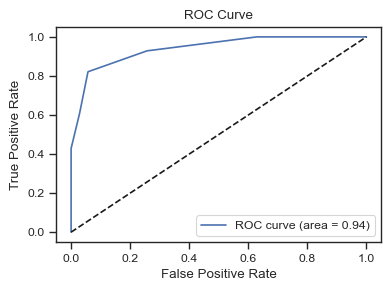

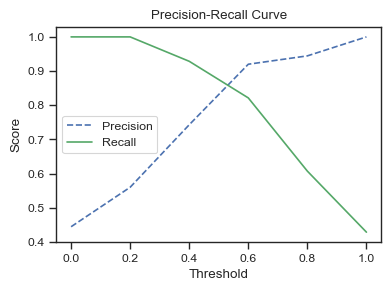

Model: KNN Distance Weighted


,precision,recall,f1-score,support
0,82.05%,91.43%,86.49%,35
1,87.50%,75.00%,80.77%,28
accuracy,,,84.13%,63
macro avg,84.78%,83.21%,83.63%,63
weighted avg,84.47%,84.13%,83.95%,63


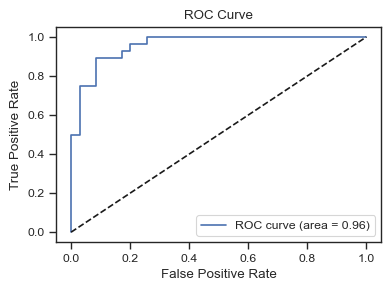

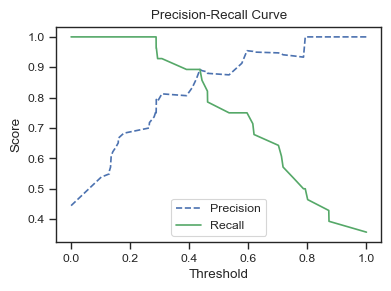

Model: KNN Condensed Nearest Neighbor


,precision,recall,f1-score,support
0,91.67%,94.29%,92.96%,35
1,92.59%,89.29%,90.91%,28
accuracy,,,92.06%,63
macro avg,92.13%,91.79%,91.93%,63
weighted avg,92.08%,92.06%,92.05%,63


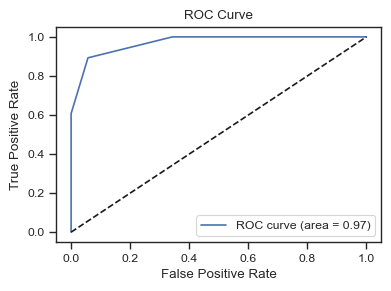

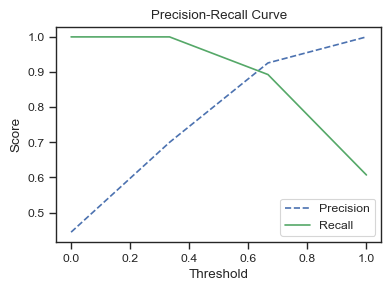

Model: KNN Locally Adaptive


,precision,recall,f1-score,support
0,94.12%,91.43%,92.75%,35
1,89.66%,92.86%,91.23%,28
accuracy,,,92.06%,63
macro avg,91.89%,92.14%,91.99%,63
weighted avg,92.13%,92.06%,92.08%,63


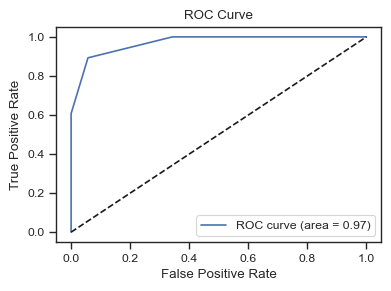

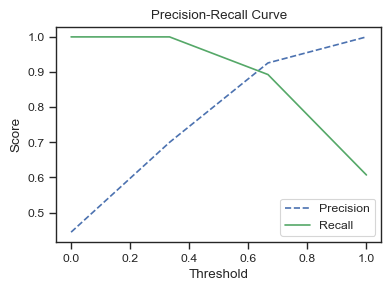

Model: Decision Tree


,precision,recall,f1-score,support
0,85.71%,68.57%,76.19%,35
1,68.57%,85.71%,76.19%,28
accuracy,,,76.19%,63
macro avg,77.14%,77.14%,76.19%,63
weighted avg,78.10%,76.19%,76.19%,63


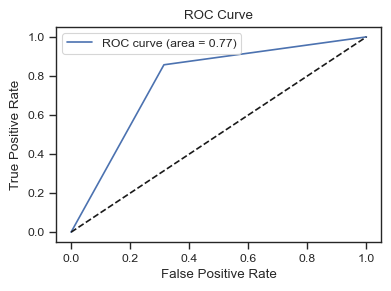

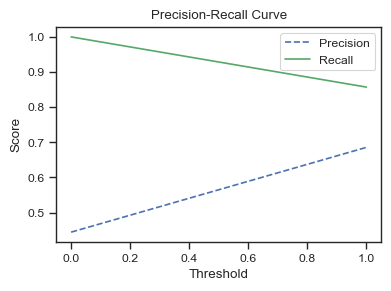

Model: Random Forest


,precision,recall,f1-score,support
0,80.00%,91.43%,85.33%,35
1,86.96%,71.43%,78.43%,28
accuracy,,,82.54%,63
macro avg,83.48%,81.43%,81.88%,63
weighted avg,83.09%,82.54%,82.27%,63


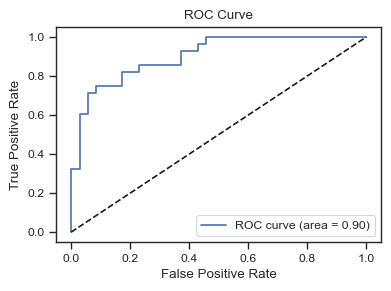

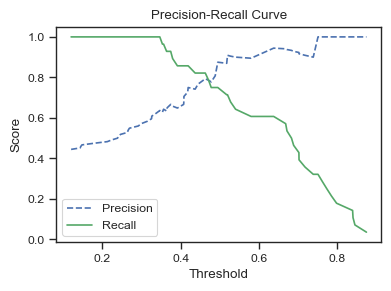

Model: Random Forest - cost-sensitive learning


,precision,recall,f1-score,support
0,81.08%,85.71%,83.33%,35
1,80.77%,75.00%,77.78%,28
accuracy,,,80.95%,63
macro avg,80.93%,80.36%,80.56%,63
weighted avg,80.94%,80.95%,80.86%,63


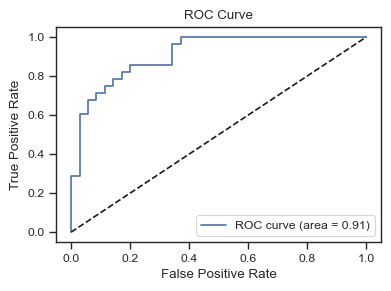

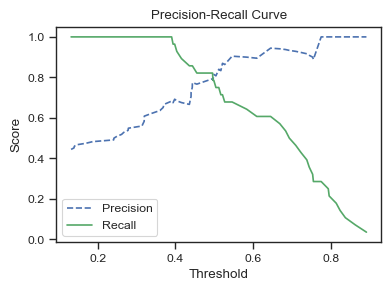

Model: AdaBoost


,precision,recall,f1-score,support
0,86.84%,94.29%,90.41%,35
1,92.00%,82.14%,86.79%,28
accuracy,,,88.89%,63
macro avg,89.42%,88.21%,88.60%,63
weighted avg,89.13%,88.89%,88.80%,63


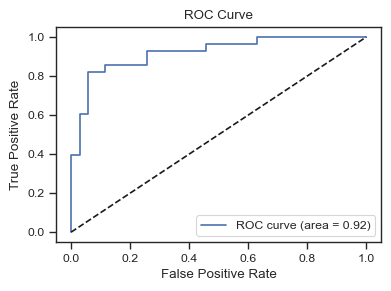

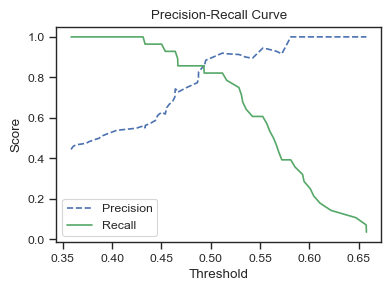

Model: Gradient Boosting


,precision,recall,f1-score,support
0,82.76%,68.57%,75.00%,35
1,67.65%,82.14%,74.19%,28
accuracy,,,74.60%,63
macro avg,75.20%,75.36%,74.60%,63
weighted avg,76.04%,74.60%,74.64%,63


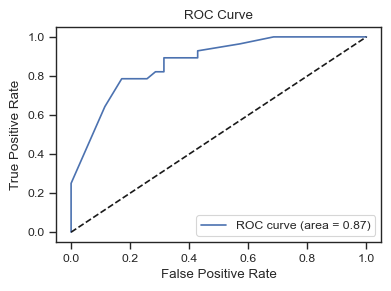

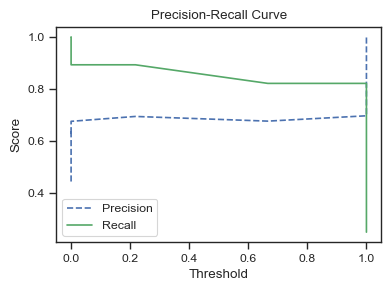

Model: SVM


,precision,recall,f1-score,support
0,87.10%,77.14%,81.82%,35
1,75.00%,85.71%,80.00%,28
accuracy,,,80.95%,63
macro avg,81.05%,81.43%,80.91%,63
weighted avg,81.72%,80.95%,81.01%,63


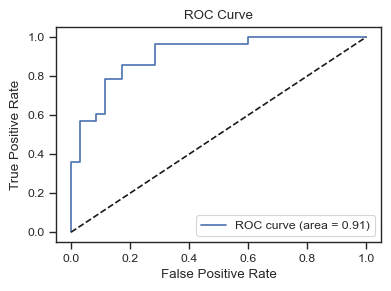

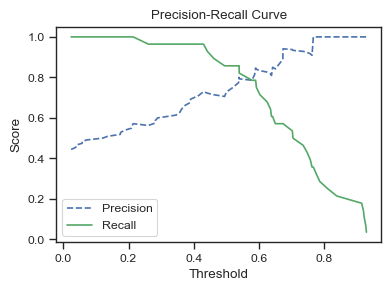

Model: SVM non linéaire


,precision,recall,f1-score,support
0,85.71%,68.57%,76.19%,35
1,68.57%,85.71%,76.19%,28
accuracy,,,76.19%,63
macro avg,77.14%,77.14%,76.19%,63
weighted avg,78.10%,76.19%,76.19%,63


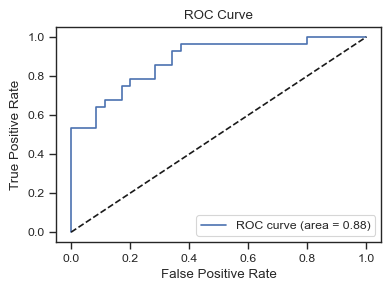

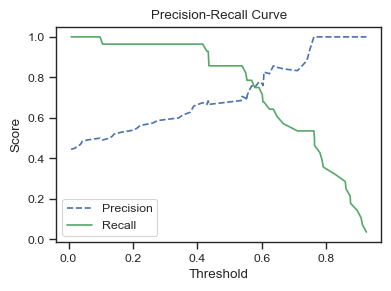

Model: SVM non linéaire avec SMOTE


,precision,recall,f1-score,support
0,93.94%,88.57%,91.18%,35
1,86.67%,92.86%,89.66%,28
accuracy,,,90.48%,63
macro avg,90.30%,90.71%,90.42%,63
weighted avg,90.71%,90.48%,90.50%,63


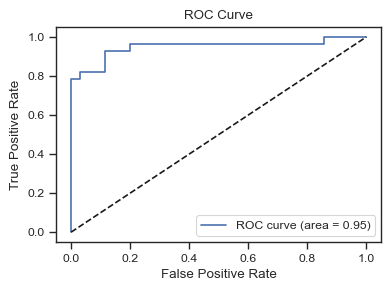

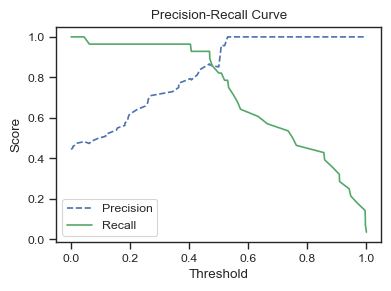

Model: SVM cost-sensitive learning


,precision,recall,f1-score,support
0,90.91%,85.71%,88.24%,35
1,83.33%,89.29%,86.21%,28
accuracy,,,87.30%,63
macro avg,87.12%,87.50%,87.22%,63
weighted avg,87.54%,87.30%,87.33%,63


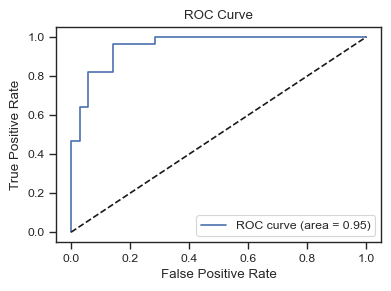

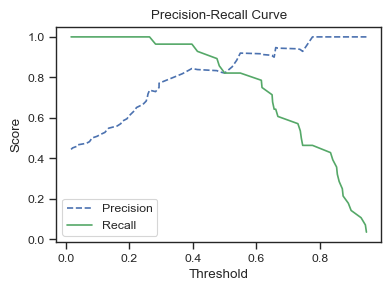

Model: Logistic Regression


,precision,recall,f1-score,support
0,90.32%,80.00%,84.85%,35
1,78.12%,89.29%,83.33%,28
accuracy,,,84.13%,63
macro avg,84.22%,84.64%,84.09%,63
weighted avg,84.90%,84.13%,84.18%,63


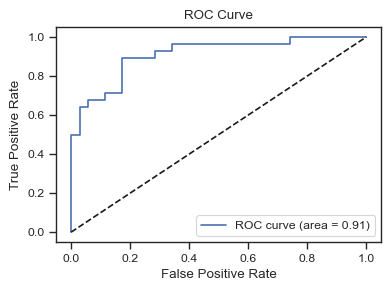

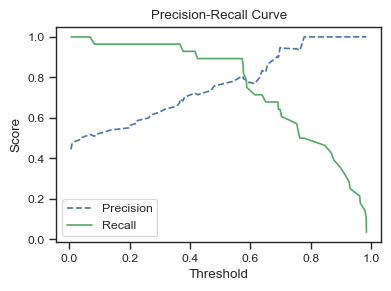

In [25]:
from utils import plot_roc, plot_precision_recall, table_report

for model_name, model in MODELS.items():
    print(f"Model: {model_name}")
    table_report(model['y_true'], model['y_pred'])
    plot_roc(model['y_true'], model['y_proba'][:, 1])
    plot_precision_recall(model['y_true'], model['y_proba'][:, 1])